# Model Testing
This notebook tests the models created in "Model Training".

## Imports


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, istft
import tensorflow as tf
from ipywidgets import interact
from code.stftprocessing import StftDataset
from code.dsvisual import DatasetVisualizer
from tqdm import tqdm
import datetime


2023-04-18 16:20:19.168311: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Load the model
Load the model stored at the _model_path_.

In [2]:
model_path = "model/model-28-03-2023"
new_model_path = "model/model-29-03-h1401-p2941361"

In [3]:
model = tf.keras.models.load_model(model_path)
new_model = tf.keras.models.load_model(new_model_path)

2023-04-18 16:20:34.660335: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-18 16:20:34.663524: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-04-18 16:20:34.712566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-18 16:20:34.712844: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: NVIDIA GeForce GTX 970 computeCapability: 5.2
coreClock: 1.253GHz coreCount: 13 deviceMemorySize: 3.93GiB deviceMemoryBandwidth: 208.91GiB/s
2023-04-18 16:20:34.712868: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-04-18 16:20:34.927213: I tensorflow/stream_executor/platform/def

## Processing input to the model
The model takes STFT amplitude data.

Write a function that processes a waveform so that it is usable by the model.

This function can then denoise a given waveform directly without preprocessing it into STFT.

In [4]:
def denoise_waveform(waveform, model=model, fs = 0.2):
    # process into STFT
    f,t, result_stft = stft(waveform, fs =fs)

    # get the amplitude
    amp = np.absolute(result_stft)
    phase = np.angle(result_stft)
    # reshape for model
    amp_reshaped = amp.reshape((1, amp.shape[0], amp.shape[1]))
    
    # model predict
    result = model.predict(amp_reshaped)
    
    # process data from STFT into time domain form
    t, signal = istft(result*np.exp(1j*phase), fs = fs)
    signal = signal.reshape(signal.shape[1])
    return signal

## Load the data
Load the time domain waveform data.

In [5]:
data_folder = "data/q3/"


In [6]:
waveforms = np.load(data_folder + "full_waveform_data.npy")
num_waveforms = waveforms.shape[0]

## Display an example waveform
The seismic data of the chosen quality level is stored in the waveforms array.

Display a randomly chosen example waveform from it.

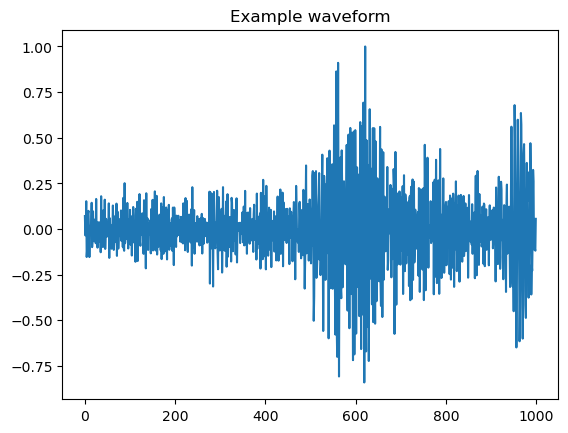

In [7]:
example_index = int(np.random.rand()*num_waveforms)
test_waveform = waveforms[example_index]


plt.plot(test_waveform)
plt.title("Example waveform")
plt.show()

In [8]:
denoised_waveform = denoise_waveform(test_waveform)

2023-04-18 16:20:41.802305: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-04-18 16:20:41.892451: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3593325000 Hz
2023-04-18 16:20:42.253568: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


In [9]:
denoised_waveform.shape

(1024,)

In [10]:
def plot_denoise(index):
    
    # define an array to map the waveforms to (5s sample space)
    time = np.linspace(0, 5000, num = 1000, endpoint=False)
    
    current_waveform = waveforms[index]
    denoised_waveform = denoise_waveform(current_waveform)
    
    fig, [ax1, ax2] = plt.subplots(1,2)
    fig.set_size_inches((12,8))
    
    # ax 1 plot: original and denoised
    ax1.plot(time, current_waveform)
    ax1.plot(time, denoised_waveform[:1000], alpha=0.7)
    ax1.set_title('Original and denoised', fontsize=15)
    ax1.set_xlabel('Time [sec]', fontsize=15)
    ax1.set_ylabel('z-displacement [no unit]', fontsize=15)
    # ax 2 plot: noise difference
    # the denoised waveform result has a shape of (1024,)
    ax2.plot(time, current_waveform - denoised_waveform[:1000])
    
    ax2.set_title('Difference between original and denoised', fontsize=15)
    ax2.set_xlabel('Time [sec]', fontsize=15)
    plt.show()

In [11]:
interact(plot_denoise, index=(0,num_waveforms, 1))

interactive(children=(IntSlider(value=80, description='index', max=160), Output()), _dom_classes=('widget-inte…

<function __main__.plot_denoise(index)>

## Compare two models
Compare the big model with 2,941,361 parameters with the smaller one

In [12]:
def plot_denoise_both(index):
    current_waveform = waveforms[index]
    denoised_waveform = denoise_waveform(current_waveform, model=model)
    denoised_waveform_model2 = denoise_waveform(current_waveform, model=new_model)
    
    fig, [ax1, ax2] = plt.subplots(1,2)
    fig.set_size_inches((8,6))
    ax1.plot(current_waveform)
    ax1.plot(denoised_waveform, alpha=0.4)
    ax1.plot(denoised_waveform_model2, alpha=0.4)

    # ax2.plot(current_waveform)
    ax2.plot(denoised_waveform, alpha=0.4)

    ax2.plot(denoised_waveform_model2, alpha=0.4)
    plt.show()

In [13]:
interact(plot_denoise_both, index=(0,num_waveforms, 1))

interactive(children=(IntSlider(value=80, description='index', max=160), Output()), _dom_classes=('widget-inte…

<function __main__.plot_denoise_both(index)>

# Quality assessment of denoising
There is no real signal to be checked against, a simple error calculation based on difference is therefore not suitable.

An alternative measure is to check how much a distribution is Gaussian.

In [14]:
def plot_difference_dist(index):
    current_waveform = waveforms[index]
    denoised_waveform = denoise_waveform(current_waveform, model=model)
    difference = current_waveform - denoised_waveform[:1000]
    
    fig, [ax1, ax2, ax3] = plt.subplots(1,3)
    fig.set_size_inches((8,6))
    ax1.plot(current_waveform)
    ax1.plot(denoised_waveform, alpha=0.4)
    ax1.set_title("Original and denoised")

    # ax2.plot(current_waveform)
    ax2.plot(difference)
    ax2.set_title("Residual noise")

    ax3.hist(difference, bins=60)
    ax3.set_title("Distribution of residual noise")
    
    plt.show()

In [15]:
interact(plot_difference_dist, index=(0,num_waveforms-1, 1))

interactive(children=(IntSlider(value=79, description='index', max=159), Output()), _dom_classes=('widget-inte…

<function __main__.plot_difference_dist(index)>

### Discussion
The difference in the distribution seems to be negligible from visual inspection. 

The difference will likely be in the order a few percentage points.

The difference in signal will be due to high values to either side of zero. This means the property of being "long-tailed" will be releveant.

## Processing for quality assessment
All the waveforms need to be denoised.

Most ideas for quality assessment right now focus on assessing the quality of the residual noise, i.e. the noise that is being denoised.

If the noise follows a Gaussian distribution with not a large amount of outliers (i.e. signal remains), the denoising can be considered succesful.

Therefore storing the residual noise is also useful.

In [16]:
denoised_waveforms = []
residuals_noise = []

for waveform in waveforms:
    denoising_result = denoise_waveform(waveform)[:1000]
    residual_noise_result = waveform - denoising_result
    denoised_waveforms.append(denoising_result)
    residuals_noise.append(residual_noise_result)

In [17]:
residuals_noise_array = np.array(residuals_noise)
denoised_waveforms_array = np.array(denoised_waveforms)

## Quality assessment using variance
The variance of the distribution should be close.

In [18]:
residual_mean = np.mean(np.abs(residuals_noise_array), axis=1)
residual_var = np.var(np.abs(residuals_noise_array), axis=1)
residual_var_qual = residual_mean/residual_var
residual_var_qual_norm = residual_var_qual/np.max(residual_var_qual)

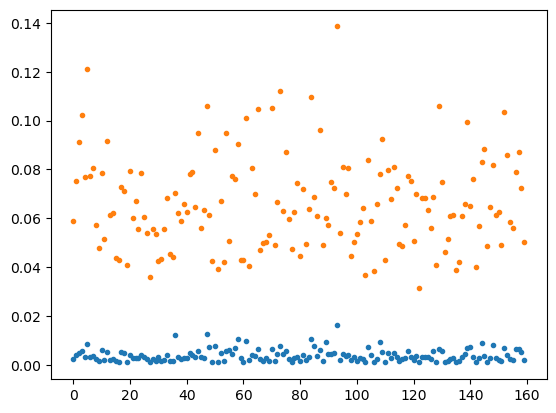

In [19]:
plt.plot(residual_var, ".")
plt.plot(residual_mean, ".")

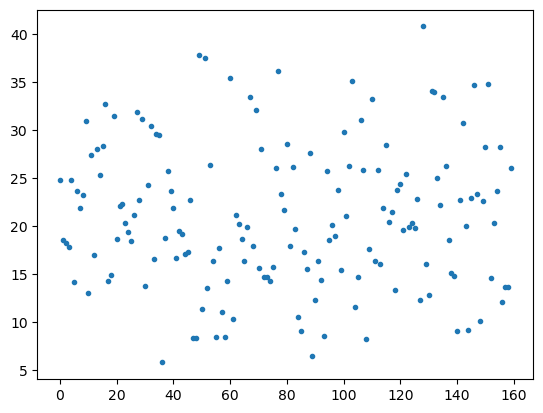

In [20]:
plt.plot(residual_mean/residual_var,".")

In [21]:
def interact_plot_qual1(index):
    quality = residual_var_qual_norm[index]
    plt.title(f"Quality is {quality}")
    plt.plot(residuals_noise_array[index])
    plt.show()

In [22]:
interact(interact_plot_qual1, index=(0,num_waveforms-1, 1))

interactive(children=(IntSlider(value=79, description='index', max=159), Output()), _dom_classes=('widget-inte…

<function __main__.interact_plot_qual1(index)>

(array([  3.,  10.,  26.,  72., 605., 236.,  47.,  17.,   6.,   2.]),
 array([-0.89630637, -0.70896786, -0.52162935, -0.33429083, -0.14695232,
         0.04038619,  0.2277247 ,  0.41506322,  0.60240173,  0.78974024,
         0.97707876]),
 <BarContainer object of 10 artists>)

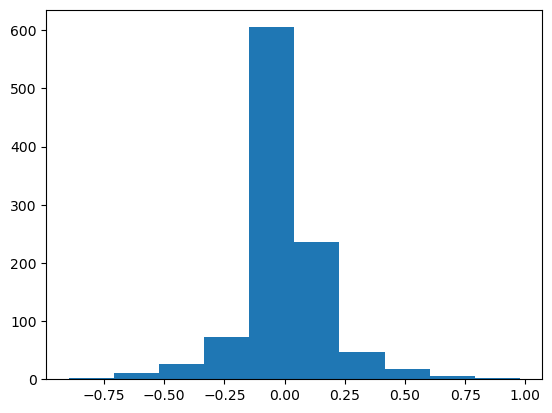

In [23]:
plt.hist(denoise_waveform(test_waveform))

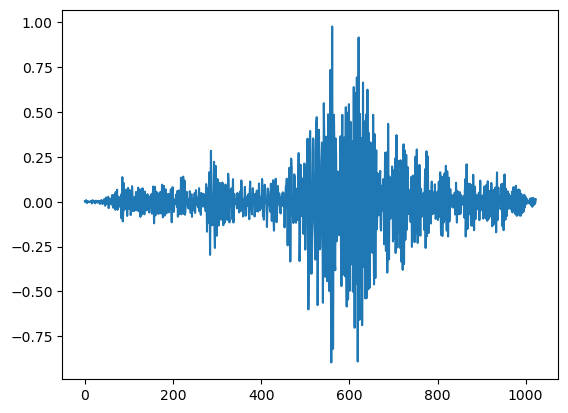

In [24]:
plt.plot(denoise_waveform(test_waveform))

Still to do:
using variance of segments in a meaningful way

## Quality assessment using ratio of mean of segments
Here, the idea is to split up the waveform into several time segments.

Then, taking the mean of the absolute values on each segment and comparing highest to lowest gives a good estimate of the distribution of the noise.
The goal is to have quality 1 (highest to lowest- 1:1) as best possible value with lower numbers representing more and more signal present

In [25]:
def assess_quality(waveform, method="segments"):
    """ this function denoises the input waveform and assesses it quality
    by analyzing comparing highest to lowest segment
    """

    denoised_waveform = denoise_waveform(waveform)[:1000]
    
    # calculate the residual noise and split into segments
    num_segments = 100
    residual_noise = denoised_waveform - waveform
    splits = np.split(residual_noise, num_segments)
    
    # calculate the mean of the absolute values
    splits_mean = np.mean(np.abs(splits), axis=1)
    
    # ratio = np.min(splits_mean)/np.max(splits_mean)
    ratio = np.var(splits_mean)
    
    return ratio

In [26]:
num_waveforms = waveforms.shape[0]
quality_assessment = np.zeros(num_waveforms)

for i in tqdm(range(num_waveforms)):
    ratio = assess_quality(waveforms[i])
    quality_assessment[i] = ratio

100%|█████████████████████████████████████████| 160/160 [00:02<00:00, 56.06it/s]


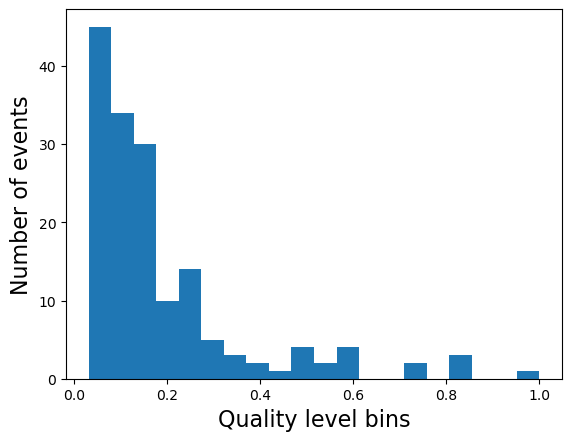

In [27]:
hist_bins = plt.hist(quality_assessment/np.max(quality_assessment), bins = 20)
plt.xlabel("Quality level bins", fontsize=16)
plt.ylabel("Number of events", fontsize=16)
plt.show()

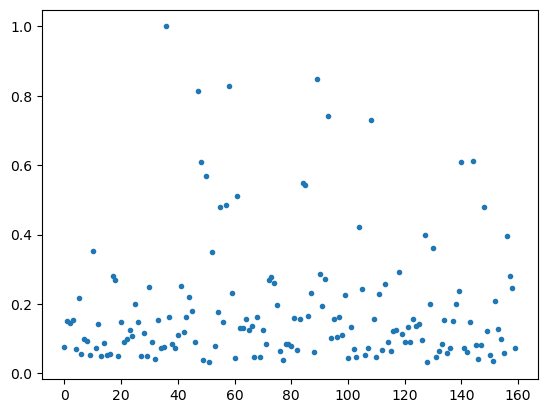

In [28]:
plt.plot(quality_assessment/np.max(quality_assessment),".")
# plt.plot(residual_var_qual_norm,".", alpha= 0.2)

In [29]:
quality_assessment[153]

0.0009544362195246826

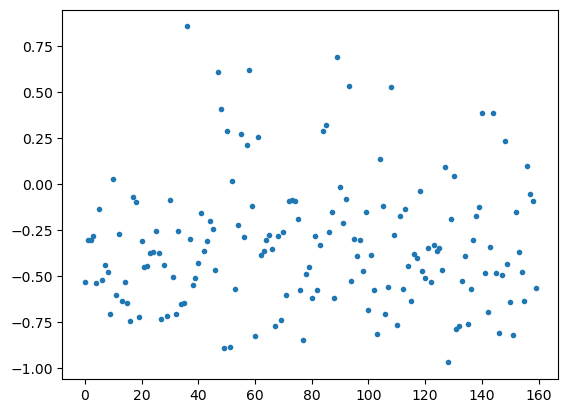

In [30]:
plt.plot(quality_assessment/np.max(quality_assessment) - residual_var_qual_norm, ".")

In [31]:
def interact_plot_qual1(index):
    quality = quality_assessment[index]/np.max(quality_assessment)
    time = np.linspace(0, 5000, num = 1000, endpoint=False)

    plt.title(f"Quality is {quality}", fontsize=16)
    plt.plot(time, residuals_noise_array[index])
    plt.ylabel("residual noise", fontsize=16)
    plt.xlabel("time [s]", fontsize=16)
    plt.show()

In [32]:
interact(interact_plot_qual1, index=(0,num_waveforms-1, 1))

interactive(children=(IntSlider(value=79, description='index', max=159), Output()), _dom_classes=('widget-inte…

<function __main__.interact_plot_qual1(index)>

## Assessing new information
In this section the denoised waveforms will be compared against the set of original waveforms in the testset.

Are the denoised results actually new waveforms?

In [33]:
folder = "training/original training/"
file = 'original_training_no_aug.npy'

In [34]:
original_set = np.load(folder + file)

In [35]:
denoised_waveforms_array.shape

(160, 1000)

In [36]:
original_set.shape

(132, 1000)

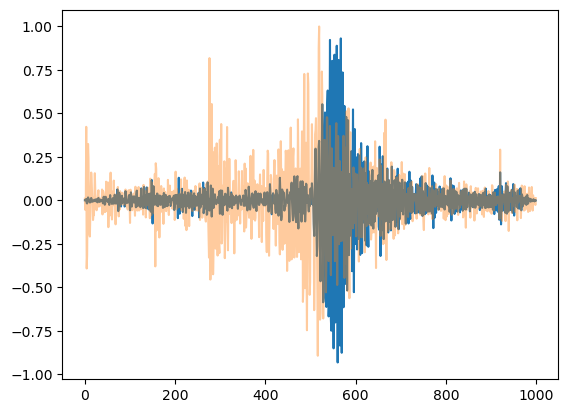

In [37]:
index = 0
plt.plot(denoised_waveforms[index])
plt.plot(original_set[index], alpha=0.4)

In [38]:
denoised_compare_base = denoised_waveforms[1]

mean_compare = np.mean(original_set-denoised_compare_base, axis=1)
var_compare = np.var(original_set-denoised_compare_base, axis=1)

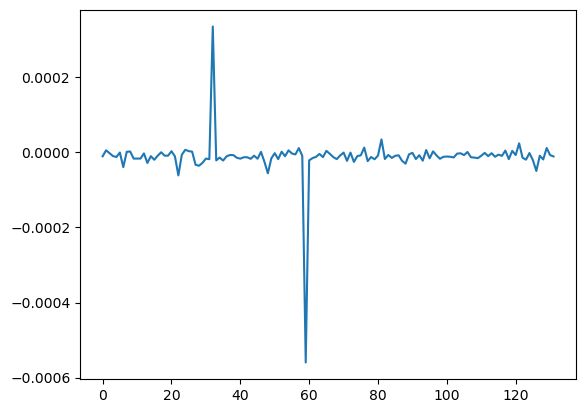

In [39]:
plt.plot(mean_compare)

In [40]:
np.argmin(np.absolute(mean_compare))

5

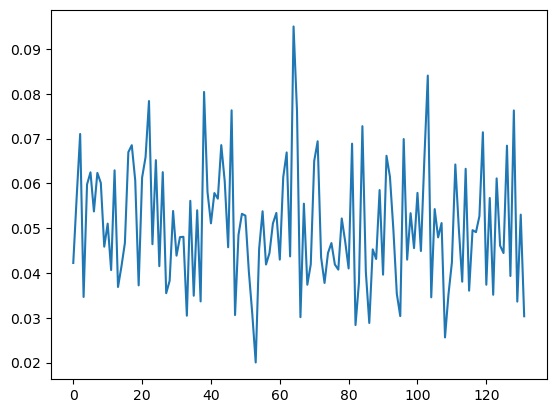

In [41]:
plt.plot(var_compare)

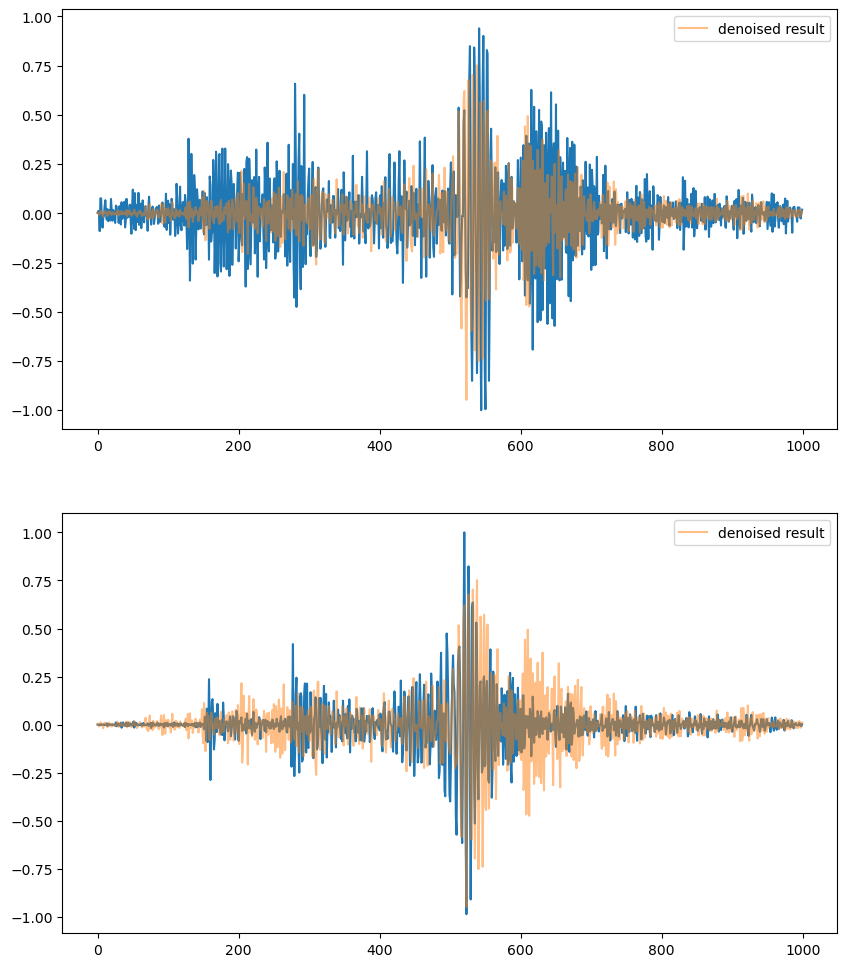

In [42]:
# get the best fit of the comparison
best_fit_mean = np.argmin(np.absolute(mean_compare))
best_fit_var = np.argmin(var_compare)
# 
fig, [ax1, ax2] = plt.subplots(2,1)

fig.set_size_inches((10,12))
ax1.plot(original_set[best_fit_mean])
ax1.plot(denoised_compare_base, alpha=0.5, label="denoised result")
ax1.legend()

ax2.plot(original_set[best_fit_var])
ax2.plot(denoised_compare_base, alpha=0.5, label="denoised result")
ax2.legend()

In [43]:
from sklearn.metrics import mutual_info_score

# Generate two arrays of data
x = [1, 2, 1, 2, 1, 2]
y = [1, 1, 2, 2, 1, 1]

# Compute the mutual information between the arrays
mutual_info = mutual_info_score(x, y)

print(mutual_info)


0.0


## Assessment using normaltest
Scipy provides a normaltest function that measures how normally distributed the given input is.

The SciPy package method actually tests "the null hypothesis that a sample comes from a normal distribution" (source: scipy doc).

This means the null hypothesis represents the existence of a normal distribution.

The p-value measures how likely the null-hypothesis is correct given the observed data. Or more in detail: how likely a result like the observed result (or even a more extreme one) actually is given that the null hypothesis is correct. So a high p-value means the result can be realistic if the null hypothesis is  correct.

In the normaltest of the SciPy package the null hypothesis is that there is a normal distribution underlying the data, so a high p-value actually means that the input is normally distributed.

The statistic output is a combined measure of the skewness and kurtosis scores provided by other tests of the scipy package. Here, the lower the number the better.

In [44]:
from scipy.stats import normaltest

# Generate some random data
data = np.random.normal(0, 1, size=100)

# Test for normality
statistic, p_value = normaltest(data)

# Print the results
print(f"Normality test statistic: {statistic}")
print(f"p-value: {p_value}")


Normality test statistic: 1.535649170699882
p-value: 0.4640214101062988


In [47]:
new_data = data.copy()
new_data[10]=40

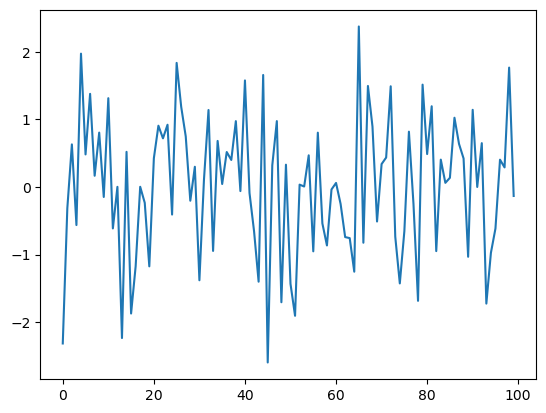

In [76]:
plt.plot(data)

In [49]:
# Test for normality
statistic, p_value = normaltest(new_data)

# Print the results
print(f"Normality test statistic: {statistic}")
print(f"p-value: {p_value}")

Normality test statistic: 204.80131410786055
p-value: 3.372560104225592e-45


In [90]:
# calculate the properties of the distribution
p_value_list = []
statistic_list = []

for noise in residuals_noise_array:
    statistic, p_value = normaltest(noise*2)

    p_value_list.append(p_value)
    statistic_list.append(statistic)
    
p_values = np.array(p_value_list)
statistics = np.array(statistic_list)

In [110]:
def interact_plot_quality_pvalue(index):
    quality = p_values[index]
    time = np.linspace(0, 5000, num = 1000, endpoint=False)

    plt.title(f"Quality is p-value= {quality:02.5}", fontsize=16)
    plt.plot(time, residuals_noise_array[index])
    plt.ylabel("residual noise", fontsize=16)
    plt.xlabel("time [s]", fontsize=16)
    plt.show()

In [111]:
interact(interact_plot_quality_pvalue, index=(0,num_waveforms-1, 1))

interactive(children=(IntSlider(value=79, description='index', max=159), Output()), _dom_classes=('widget-inte…

<function __main__.interact_plot_quality_pvalue(index)>

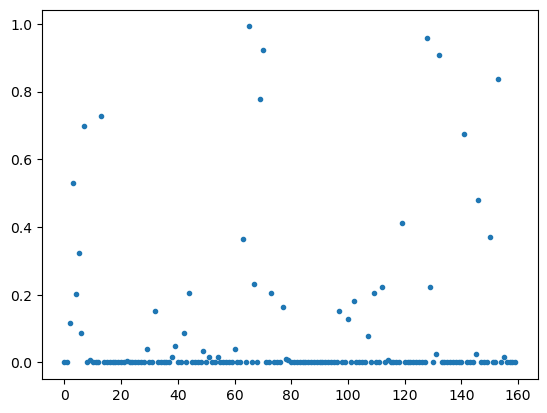

In [78]:
plt.plot(p_values,".")

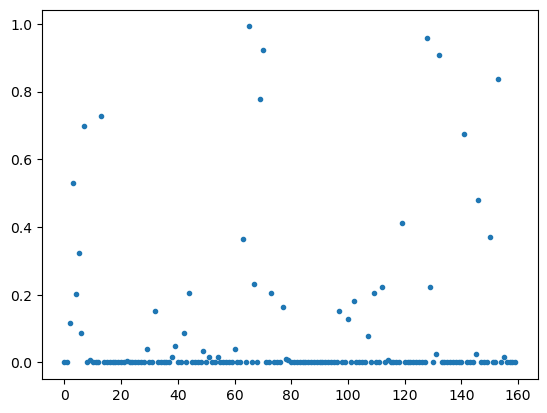

In [99]:
plt.plot(p_values,".")

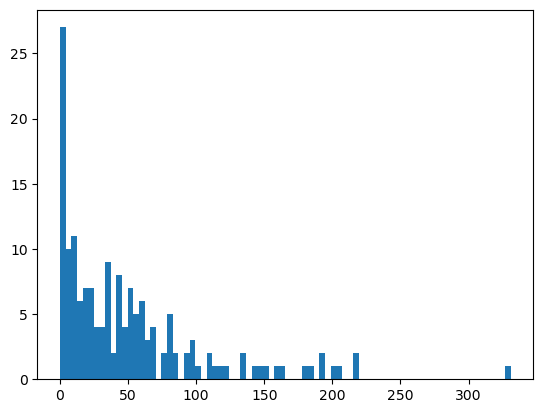

In [79]:
plt.hist(statistics, bins=80)
plt.show()

In [75]:
# help(np.where)
np.where(p_values > 0.05)

(array([  2,   3,   4,   5,   6,   7,  13,  32,  42,  44,  63,  65,  67,
         69,  70,  73,  77,  97, 100, 102, 107, 109, 112, 119, 128, 129,
        132, 141, 146, 150, 153]),)

In [112]:
np.where(p_values > 0.0000001)[0].shape

(75,)

In [80]:
normalized_quality_assessment = quality_assessment/np.max(quality_assessment)

In [86]:
np.where(normalized_quality_assessment<0.1)

(array([  0,   4,   6,   8,   9,  11,  13,  14,  15,  16,  19,  21,  22,
         27,  29,  31,  32,  34,  35,  38,  39,  46,  49,  51,  53,  60,
         67,  69,  71,  76,  77,  78,  79,  80,  82,  88, 100, 102, 103,
        106, 107, 110, 112, 114, 115, 120, 122, 126, 128, 131, 132, 133,
        135, 136, 141, 142, 145, 146, 147, 150, 151, 155, 159]),)

In [113]:
p_values.shape

(160,)